In [1]:
import numpy as np
import pandas as pd
import transformers
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import TwitterDataset
from model import SarcasmDetectionModel
from util import train_model, plot_loss, plot_accuracies, get_failed_examples, save_failed_examples

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Global Variables
device = "cuda" if torch.cuda.is_available() else "cpu"
twitter_train_dir = "twitter_train.csv"
twitter_test_dir = "twitter_test.csv"
model_save_path = "model.pth"
loss_save_path = "losses.png"
acc_save_path = "accuracies.png"
failed_examples_save_path = "failed_examples.json"
seed = 25

# Hyperparameters
len_dataset = 6000
batch_size = 64
lr = 3e-6
n_epoch = 5

In [3]:
# Load the data and shuffle it
print("Loading data...")

df = pd.read_csv(twitter_train_dir)
df = df[(df["class"] == "sarcasm") | (df["class"] == "regular")]
# Sample 3000 rows from each class for the training dataset
train_sarcasm_sample = df[df["class"] == "sarcasm"].sample(n=len_dataset//2, random_state=seed)
train_regular_sample = df[df["class"] == "regular"].sample(n=len_dataset//2, random_state=seed)
# Combine the sampled training data
twitter_train_dataset = pd.concat([train_sarcasm_sample, train_regular_sample])

df = pd.read_csv(twitter_test_dir)
twitter_test_dataset = df[(df["class"] == "sarcasm") | (df["class"] == "regular")]

print(f"Instances of each sample in the entire dataset: {twitter_train_dataset['class'].value_counts()}")

Loading data...
Instances of each sample in the entire dataset: class
sarcasm    3000
regular    3000
Name: count, dtype: int64


In [4]:
# Load the pre-trained BERT model
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, "bert-base-uncased")
# model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, "distilbert-base-uncased")

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [5]:
# Replace class labels "sarcasm" with 1 and "regular" with 0
twitter_train_dataset["class"] = twitter_train_dataset["class"].replace({"sarcasm": 1, "regular": 0})
twitter_test_dataset["class"] = twitter_test_dataset["class"].replace({"sarcasm": 1, "regular": 0})

# Tokenize the dataset
tokenized_train_dataset = twitter_train_dataset["tweets"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test_dataset = twitter_test_dataset["tweets"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Padding to match the shapes of all the input data
max_len = 0
for i in tokenized_train_dataset.values:
    if len(i) > max_len:
        max_len = len(i)

padded_dataset_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train_dataset.values])

max_len = 0
for i in tokenized_test_dataset.values:
    if len(i) > max_len:
        max_len = len(i)

padded_dataset_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test_dataset.values])

print(f"Shape of the padded train dataset: {np.array(padded_dataset_train).shape}")
print(f"Shape of the padded test dataset: {np.array(padded_dataset_test).shape}")

Shape of the padded train dataset: (6000, 79)
Shape of the padded test dataset: (3964, 100)


In [6]:
# Add a mask so that the model doesn't consider padded tokens
attention_mask_train = np.where(padded_dataset_train != 0, 1, 0)
attention_mask_test = np.where(padded_dataset_test != 0, 1, 0)
print(f"Shape of the masked train dataset: {attention_mask_train.shape}")
print(f"Shape of the masked test dataset: {attention_mask_test.shape}")

Shape of the masked train dataset: (6000, 79)
Shape of the masked test dataset: (3964, 100)


In [7]:
# Create dataloaders
train_features = torch.tensor(padded_dataset_train, device=device).long()
train_mask = torch.tensor(attention_mask_train, device=device).long()
train_labels = torch.tensor(twitter_train_dataset["class"].values, device=device).long()
train_dataset = TwitterDataset(train_features, train_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_features = torch.tensor(padded_dataset_test, device=device).long()
test_mask = torch.tensor(attention_mask_test, device=device).long()
test_labels = torch.tensor(twitter_test_dataset["class"].values, device=device).long()
test_dataset = TwitterDataset(test_features, test_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Instances of each sample in the train set: {twitter_train_dataset['class'].value_counts()}")
print(f"Instances of each sample in the test set: {twitter_test_dataset['class'].value_counts()}")

Instances of each sample in the train set: class
1    3000
0    3000
Name: count, dtype: int64
Instances of each sample in the test set: class
1    2105
0    1859
Name: count, dtype: int64


In [8]:
# Define the model, optimizer and the loss function
model = SarcasmDetectionModel(bert_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

In [9]:
# Create arrays to document progress
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# Train and Evaluate the model
for epoch in range(n_epoch):
    train_loss, train_acc, test_loss, test_acc = train_model(model, optimizer, loss_function, train_loader, len(train_labels), test_loader, len(test_labels), epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Epoch 0 -> Train loss: 0.3614 Train acc: 82.72% Test acc: 99.22%
Epoch 1 -> Train loss: 0.0258 Train acc: 99.72% Test acc: 99.97%
Epoch 2 -> Train loss: 0.0068 Train acc: 99.97% Test acc: 99.97%
Epoch 3 -> Train loss: 0.0032 Train acc: 100.00% Test acc: 99.97%
Epoch 4 -> Train loss: 0.0022 Train acc: 100.00% Test acc: 99.97%


In [11]:
# Save the model
torch.save(model.state_dict(), model_save_path)

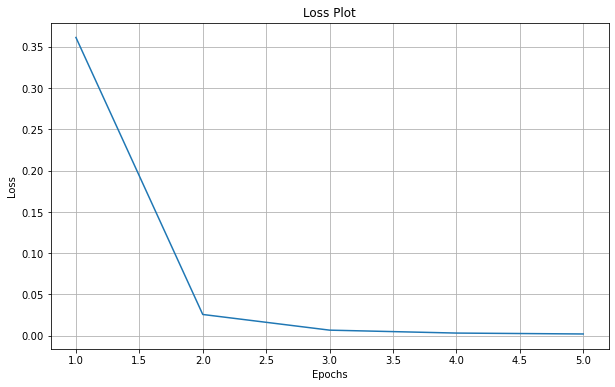

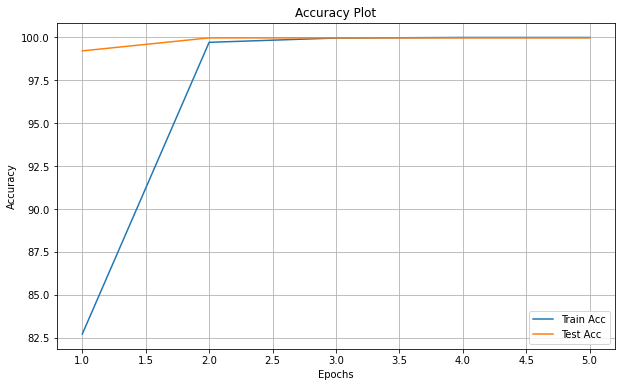

In [12]:
# Plot the results
plot_loss(train_losses, "Loss Plot", "Train Loss", "Loss", loss_save_path)
plot_accuracies(train_accuracies, test_accuracies, "Accuracy Plot", "Train Acc", "Test Acc", "Accuracy", acc_save_path)

In [13]:
# Get failed examples
failed_examples = get_failed_examples(model, test_loader, tokenizer)
save_failed_examples(failed_examples, failed_examples_save_path)

2024-06-04 06:17:22.480999: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 06:17:22.531585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
